<a href="https://colab.research.google.com/github/carloslme/ds-portfolio/blob/main/predictive-analytics/predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Predictive Analytics is a process of statistical techniques derived from data mining, machine learning and predictive modeling that obtain current and historical events to predict future events or unknown outcomes in the future.

The goal of this exercise is to build a machine learning pipeline for predictive analytics using this open dataset: https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5, which shows the road incidents in Mexico City during february 2021 in the 16 town halls.

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Ingestion

## Getting data from website 

In [2]:
!pip install requests

In [3]:
import requests

In [4]:
res = requests.get('https://datos.cdmx.gob.mx/dataset/a6d1d483-65d2-4ed9-9687-1932eb0cf70f/resource/c6b0fe65-137c-40d6-99c9-6c527f9b29c4/download/___')

In [5]:
res.raise_for_status()
csv_file = open('incidentes-viales-c5.csv', 'wb')
for chunk in res.iter_content(100000):
  csv_file.write(chunk)

csv_file.close()

## Getting data dictionary
Let's understand the meaning of each column. 

Original Data Dictionary can be found [here](https://datos.cdmx.gob.mx/dataset/a6d1d483-65d2-4ed9-9687-1932eb0cf70f/resource/49b5360c-5922-46bd-b4f8-ed0225d5ddbf/download/diccionario-de-datos-de-incidentes-viales.xlsx).

|Column|Description|
|------|-----------|
folio | Only alphanumeric code assigned to each one of the incidents generated by C5 and C2
fecha_creacion | Folio event opening date
hora_creacion | Folio event opening time
dia_semana | Folio event opening day 
fecha_cierre | Folio event closure date
hora_cierre | Folio event closure time
incidente_c4 | Type of incident
delegacion_inicio | Town hall where the incident was reported
latitud | Lattitude
longitud | Longitude
codigo_cierre | Code generated to the incident ince it was closed
clas_con_f_alarma | Incident classification
tipo_entrada | How the incident was reported 
delegacion_cierre | Town hall where the incident was closed

# Data Exploration 

## Describe data structure

In [6]:
incidents = pd.read_csv('/content/incidentes-viales-c5.csv')
incidents.head()

,Unnamed: 0,folio,fecha_creacion,hora_creacion,dia_semana,fecha_cierre,hora_cierre,incidente_c4,delegacion_inicio,latitud,longitud,codigo_cierre,clas_con_f_alarma,tipo_entrada,delegacion_cierre,ano,mes
0,1,C5/210201/04663,01/02/2021,19:14:39,Lunes,01/02/2021,20:36:48,accidente-choque con lesionados,GUSTAVO A. MADERO,19.461570,-99.115210,A,URGENCIAS MEDICAS,LLAMADA DEL 911,GUSTAVO A. MADERO,2021,2
1,2,C5/210201/00391,01/02/2021,01:02:02,Lunes,01/02/2021,01:20:09,accidente-choque sin lesionados,GUSTAVO A. MADERO,19.471440,-99.081770,N,EMERGENCIA,LLAMADA DEL 911,GUSTAVO A. MADERO,2021,2
2,3,C5/210201/03815,01/02/2021,16:49:58,Lunes,01/02/2021,19:11:53,accidente-choque con lesionados,MIGUEL HIDALGO,19.440680,-99.190980,A,URGENCIAS MEDICAS,LLAMADA DEL 911,MIGUEL HIDALGO,2021,2
3,4,C5/210201/02068,01/02/2021,11:10:52,Lunes,01/02/2021,12:24:56,accidente-choque sin lesionados,COYOACAN,19.342580,-99.148890,A,EMERGENCIA,LLAMADA DEL 911,COYOACAN,2021,2
4,5,C5/210201/03832,01/02/2021,16:52:41,Lunes,01/02/2021,17:38:14,accidente-choque con lesionados,TLALPAN,19.200021,-99.138111,N,URGENCIAS MEDICAS,LLAMADA DEL 911,TLALPAN,2021,2


In [7]:
incidents.describe()

,Unnamed: 0,latitud,longitud,ano,mes
count,12947.000000,12947.000000,12947.000000,12947.0,12947.0
mean,6474.000000,19.380217,-99.131012,2021.0,2.0
std,3737.621302,0.072025,0.061818,0.0,0.0
min,1.000000,19.098188,-99.347260,2021.0,2.0
25%,3237.500000,19.330040,-99.172050,2021.0,2.0
50%,6474.000000,19.380250,-99.134292,2021.0,2.0
75%,9710.500000,19.435890,-99.086560,2021.0,2.0
max,12947.000000,19.576320,-98.952781,2021.0,2.0


In [8]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12947 entries, 0 to 12946
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         12947 non-null  int64  
 1   folio              12947 non-null  object 
 2   fecha_creacion     12947 non-null  object 
 3   hora_creacion      12947 non-null  object 
 4   dia_semana         12947 non-null  object 
 5   fecha_cierre       12947 non-null  object 
 6   hora_cierre        12945 non-null  object 
 7   incidente_c4       12947 non-null  object 
 8   delegacion_inicio  12947 non-null  object 
 9   latitud            12947 non-null  float64
 10  longitud           12947 non-null  float64
 11  codigo_cierre      12947 non-null  object 
 12  clas_con_f_alarma  12947 non-null  object 
 13  tipo_entrada       12947 non-null  object 
 14  delegacion_cierre  12947 non-null  object 
 15  ano                12947 non-null  int64  
 16  mes                129

Showing the number of instances (on the vertical axis) that have a given value range (on the horizontal axis)

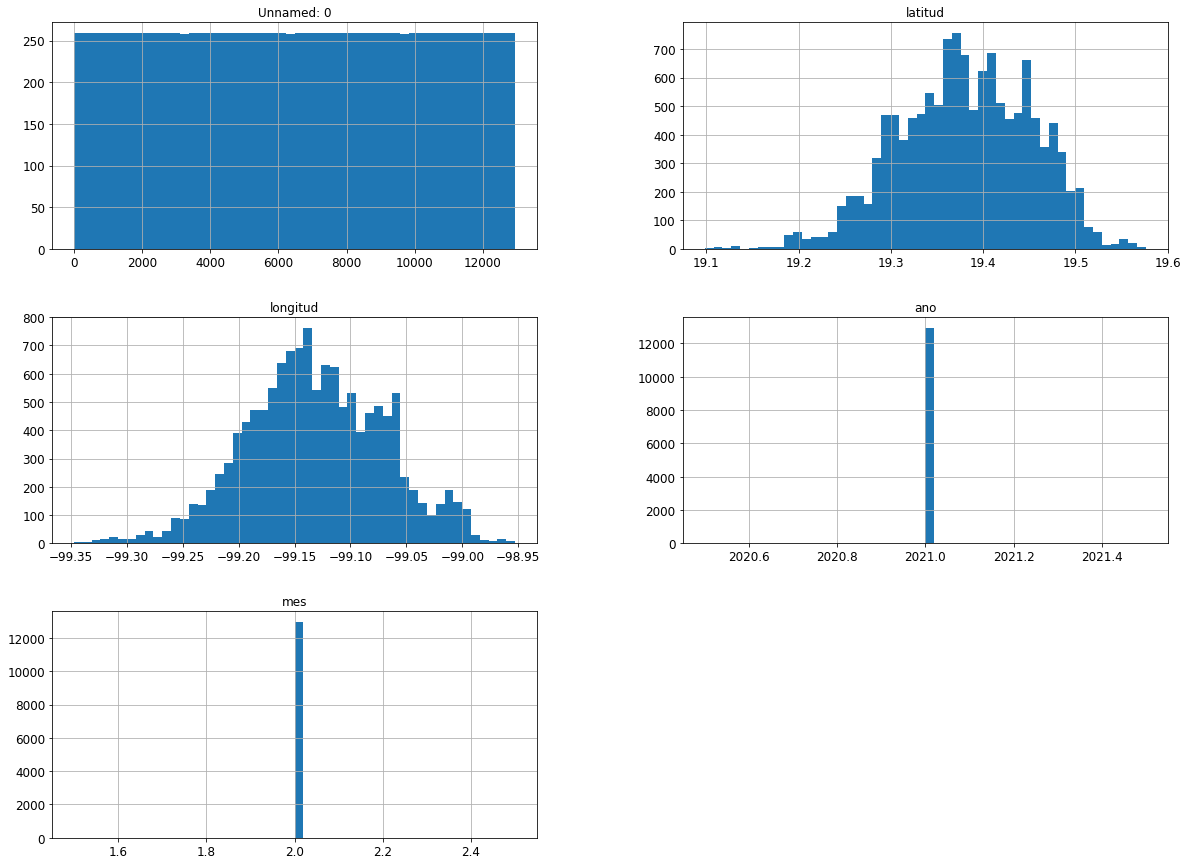

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
incidents.hist(bins=50, figsize=(20,15))
plt.show()

Few things to notice in the above histograms:
1. Not all the fields were plotted
2. The `latitud` and `longitud` data is may be represented in a map to visualize the locations (we already know that there are from Mexico City)
3. The fields `ano` and `mes` have the same just one value each one, they may be deleted later.
4. `Unnamed: 0` field is not relevant, it has to be deleted too

Visualizing the data to have a better overview of how it is distributed with a Kernel Density Estimate (KDE) plot, which is a method for visualizing the distribution of observations in a dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


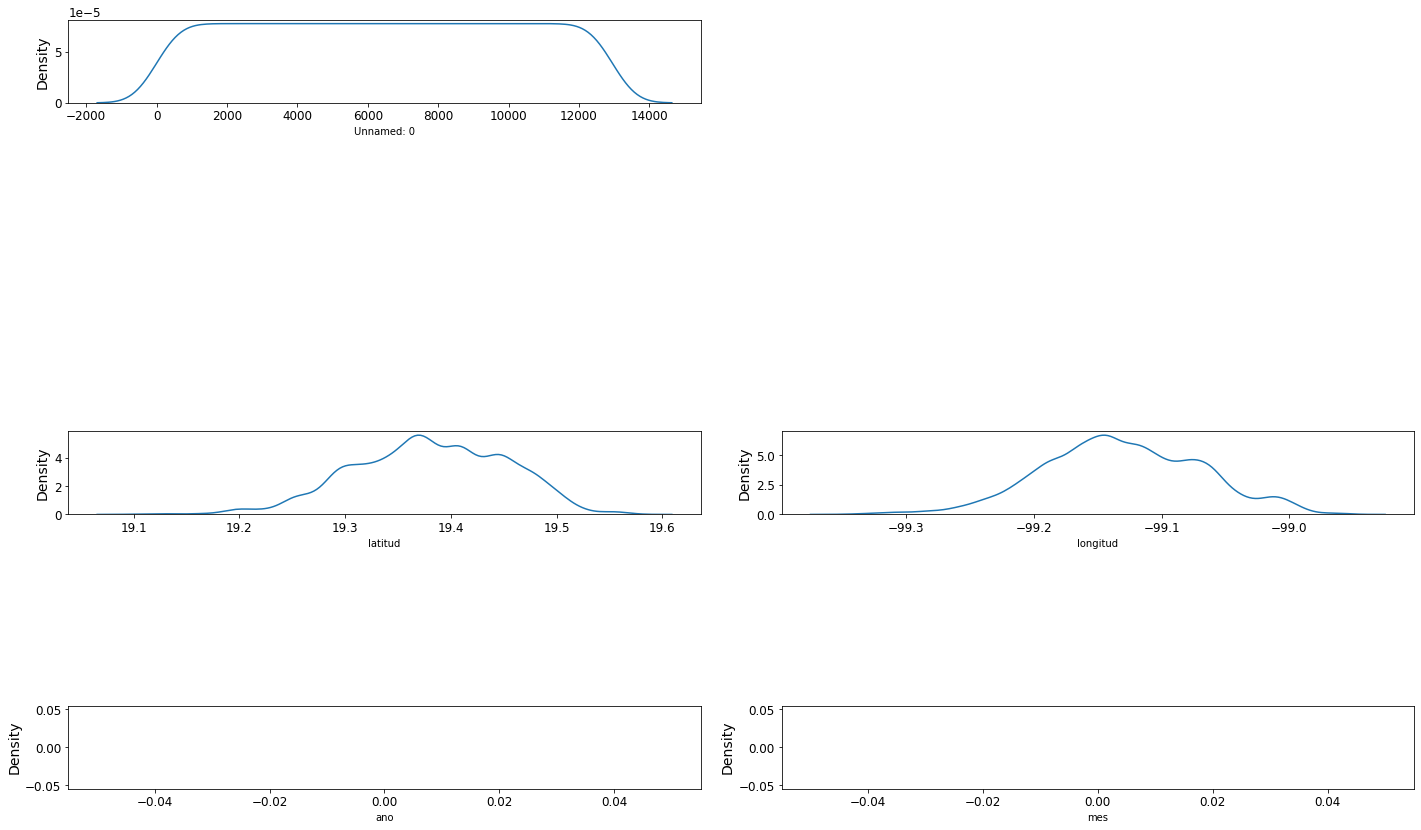

In [10]:
# Plotting Kernel Density Estimate (KDE)
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(30,40))
for i, col in enumerate(incidents.columns):
    if incidents[col].dtype != 'object':
        ax = plt.subplot(21, 3, i+1)
        sns.kdeplot(incidents[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

Same things noticed from histograms, there are missing fields such as `fecha_creacion`, `hora_creacion`. and even `dia_semana`.

## Exploring numerical attributes

[]

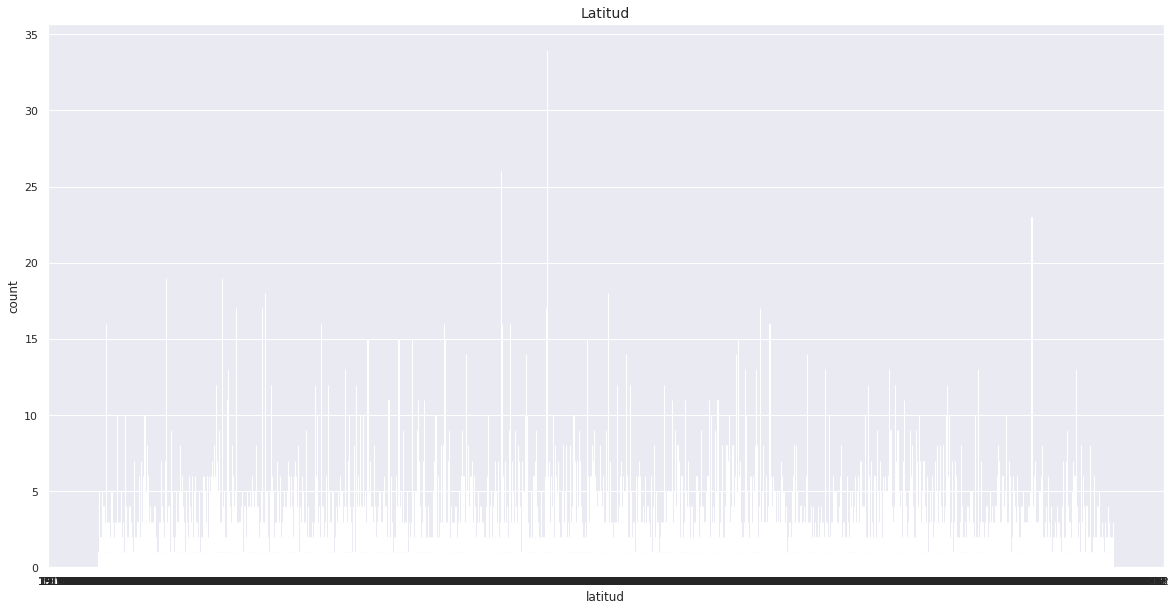

In [12]:
sns.set(rc={'figure.figsize':(20,10)})

sns.countplot('latitud', data=incidents)
plt.title('Latitud', fontsize=14)
plt.plot()

## Discover and visualize the data to gain insights

### Visualizing Geographical Data
Graphing the geographical information by latitude and longitude and using a scatterplot of all districts

In [ ]:
incidents.plot(kind='scatter', x='longitud', y='latitud')

To visualize some particular patterns, the alpha option has to be set to 0.1


In [ ]:
incidents.plot(kind='scatter', x='longitud', y='latitud', alpha=0.1)

In [ ]:
incidents.plot(kind='scatter', x='longitud', y='latitud', alpha=0.05)

We can create a map using the [Matbox API](https://colab.research.google.com/github/la-counts/data-adventures/blob/master/Instructable_6_How_to_Map_Geographic_Data_Using_Coordinates.ipynb?authuser=1#scrollTo=sxb7cAsfVNuY)

In [ ]:
!pip install chart-studio

In [ ]:
import chart_studio
from chart_studio import plotly as py
import plotly.tools as tl
import plotly.graph_objs as go
import pandas as pd

# Change API key for Plotly 

chart_studio.tools.set_credentials_file(username='carloslme', api_key='EHfn2j51fBhW5xYh6VM7')

# Add Mapbox access token here 

mapbox_access_token = 'pk.eyJ1IjoiYXNjaHJvY2siLCJhIjoiY2p2NnRoeHc2MDkxbTQ0bnR6aTVwZDNsaCJ9.MA76hkxD3rOGgnVCDBVC9w'

df = pd.read_csv('https://datos.cdmx.gob.mx/dataset/a6d1d483-65d2-4ed9-9687-1932eb0cf70f/resource/c6b0fe65-137c-40d6-99c9-6c527f9b29c4/download/___')


In [ ]:

# Save latitude and longitude as variables. In this dataset, the X column is longitude and the Y column is latitude. 

site_lat = df.latitud[:6000]
site_lon = df.longitud[:6000]
locations_name = df.incidente_c4[:6000]

# Generate the data for the map 

data = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=3,
            color='rgb(255, 0, 0)',
            opacity=1
        ),
        text=locations_name,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(242, 177, 172)',
            opacity=0.8
        ),
        hoverinfo='none'
    )]


# Generate a layout around Los Angeles, zoomed in so we can see the data points 

layout = go.Layout(
    title='CDMX Incidents - First 6000',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=19.432608,
            lon=-99.133209
        ),
        pitch=0,
        zoom=10,
        style='light'
    ),
)
	
# Generate the figure using the iplot function 
  
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='CDMX Incidents - First 6000')

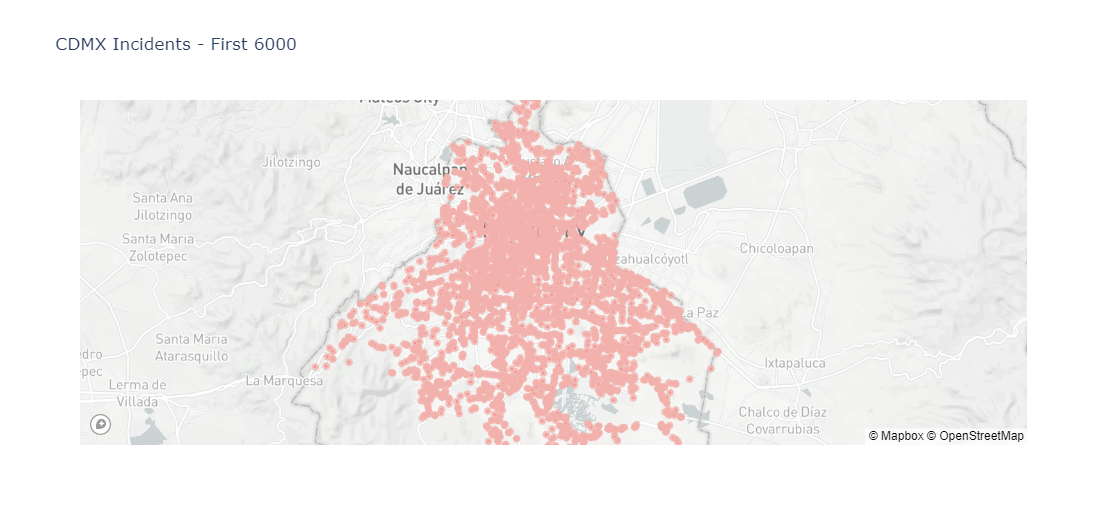

In [ ]:

# Save latitude and longitude as variables. In this dataset, the X column is longitude and the Y column is latitude. 

site_lat = df.latitud[6000:12000]
site_lon = df.longitud[6000:12000]
locations_name = df.incidente_c4[6000:12000]

# Generate the data for the map 

data = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=3,
            color='rgb(255, 0, 0)',
            opacity=1
        ),
        text=locations_name,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(242, 177, 172)',
            opacity=0.8
        ),
        hoverinfo='none'
    )]


# Generate a layout around Los Angeles, zoomed in so we can see the data points 

layout = go.Layout(
    title='CDMX Incidents - Last 6000',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=19.432608,
            lon=-99.133209
        ),
        pitch=0,
        zoom=10,
        style='light'
    ),
)
	
# Generate the figure using the iplot function 
  
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='CDMX Incidents - Last 6000')

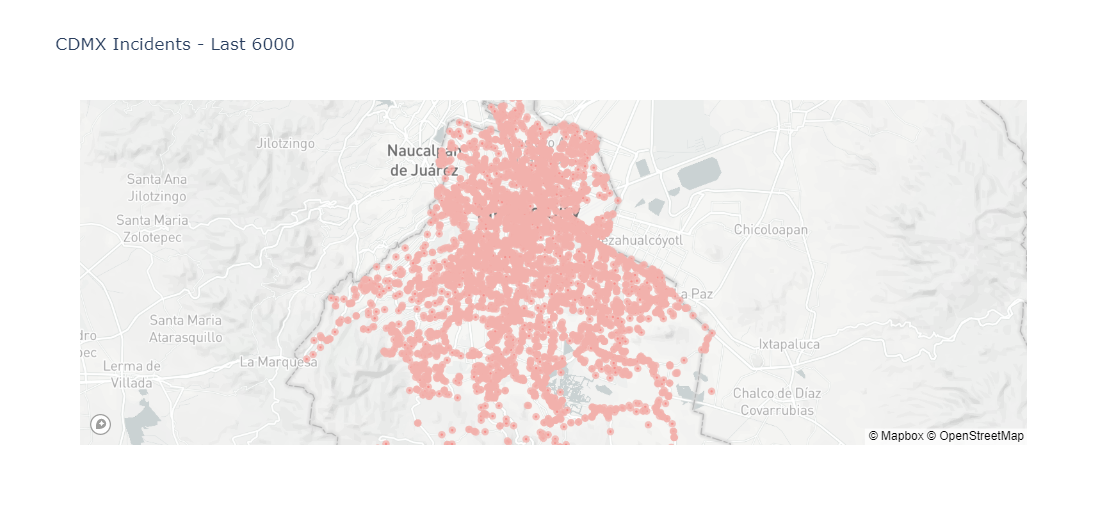

# Data Preprocessing

## Remove irrelevant columns
Apparently, the columns that seems to not contribute anything for this analysis are the following:
* `Unnamed` - Just the rows numbers
* `fecha_creacion` - irrelevant
* `fecha_cierre` - not necessary for prediction
* `hora_cierre` - not necessary for prediction
* `delegacion_inicio` - not necessary for prediction
* `delegacion_cierre` - not necessary for prediction
* `codigo_cierre` - not necessary for prediction
* `ano` - can be inferred by `fecha_creacion`
* `mes` - `fecha_creacion`

In [ ]:
incidents.drop(['Unnamed: 0', 'folio', 'fecha_creacion', 'fecha_cierre', 'hora_cierre', 'delegacion_inicio', 'codigo_cierre', 'delegacion_cierre', 'ano', 'mes'], axis=1, inplace=True)

Exploring data after remove irrelevant columns

In [ ]:
incidents.info()

In [ ]:
incidents.head(10)

In [ ]:
incidents.describe()

## Handling text and categorical attributes¶


There are several columns with text and categorical attributes. Most ML algorithms prefer to work with numbers, so it's a good idea to convert these categories from text to numbers by using the `OrdinalEncoder` class found in `sklearn`.

In [ ]:
incidents['dia_semana'].value_counts()

In [ ]:
incidents['clas_con_f_alarma'].value_counts()

In [ ]:
incidents['incidente_c4'].value_counts()

In [ ]:
incidents['tipo_entrada'].value_counts()

In [ ]:
incidents_cat = incidents[['dia_semana', 'clas_con_f_alarma', 'incidente_c4', 'tipo_entrada']]
incidents_cat.head(10)

Each of this values represents a catagory. This is called categorical attribute. Most ML algorithms prefer to work with numbers, so it's a good idea to convert theses categories from text to numbers by using de `OrdinalEncoder` class:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [ ]:
incidents_cat_encoded = ordinal_encoder.fit_transform(incidents_cat)

In [ ]:
incidents_cat_encoded[:10]

In [ ]:
ordinal_encoder.categories_

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Personalized DataframeSelector
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Pipeline for the numerical attributes

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["latitud", "longitud", "hora_creacion"])),
    ])

Pipeline for the categorical attributes

In [ ]:
cat_pipeline = Pipeline([
          ("select_cat", DataFrameSelector(['dia_semana', 'clas_con_f_alarma', 'incidente_c4', 'tipo_entrada'])),
          ("cat_encoder", OrdinalEncoder()),
])

cat_pipeline.fit_transform(incidents)

Joining the numerical and categorical pipelines

In [ ]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [ ]:
incidents_prep = preprocess_pipeline.fit_transform(incidents)
incidents_prep

## Reporting structures
Let's find any structures that can be found analyzing this dataset once it was cleaned.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

incidents_report = pd.DataFrame(incidents_prep, columns = ['latitud', 'longitud', 'hora_creacion','dia_semana', 'clas_con_f_alarma', 'incidente_c4', 'tipo_entrada'])

plt.figure(figsize=(30,40))
for i, col in enumerate(incidents_report.columns):
    if incidents_report[col].dtype != 'object':
        ax = plt.subplot(21, 3, i+1)
        sns.kdeplot(incidents_report[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

In [ ]:
incidents_report_aux = incidents_report.copy()
incidents_report_aux['dia_semana'] = pd.to_numeric(incidents_report['dia_semana'])
incidents_report_aux['clas_con_f_alarma'] = pd.to_numeric(incidents_report['clas_con_f_alarma'])
incidents_report_aux['incidente_c4'] = pd.to_numeric(incidents_report['incidente_c4'])
incidents_report_aux['tipo_entrada'] = pd.to_numeric(incidents_report['tipo_entrada'])
plt.figure(figsize=(30,40))
for i, col in enumerate(incidents_report_aux.columns):
    if incidents_report_aux[col].dtype != 'object':
        ax = plt.subplot(21, 3, i+1)
        sns.kdeplot(incidents_report_aux[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

In [ ]:
plt.figure(figsize=(30,40))
for i, col in enumerate(incidents_report_aux.columns):
    if incidents_report_aux[col].dtype != 'object':
        ax = plt.subplot(21, 2, i+1)
        sns.boxplot(incidents_report_aux[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

## Exploring data by categories

In [13]:
sns.countplot('dia_semana', data=incidents_report_aux)
plt.title('Dia semana Distribution', fontsize=14)
plt.plot()

NameError: ignored

In [ ]:
sns.countplot('clas_con_f_alarma', data=incidents_report_aux)
plt.title('Incident Classification Distribution', fontsize=14)
plt.plot()

In [ ]:
sns.countplot('incidente_c4', data=incidents_report_aux)
plt.title('Type of Incident Distribution', fontsize=14)
plt.plot()

In [ ]:
sns.countplot('tipo_entrada', data=incidents_report_aux)
plt.title('How the incident was Reported Distribution', fontsize=14)
plt.plot()

# Exploring numerical attributes

In [ ]:
sns.countplot('latitud', data=incidents_report_aux)
plt.title('Latitud Distribution', fontsize=14)
plt.plot()

In [ ]:
sns.countplot('longitud', data=incidents_report_aux)
plt.title('Longitud Distribution', fontsize=14)
plt.plot()

In [ ]:
sns.countplot('ano', data=incidents)
plt.title('Año Distribution', fontsize=14)
plt.plot()

# Modeling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 300, max_depth=30, criterion = "gini", random_state = 42)
classifier.fit(X_train, y_train)

In [ ]:
y_pred  = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

# Report

# Deployment and consumption

# Useful resources
* https://www.educba.com/predictive-analysis-vs-forecasting/?source=leftnav